In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
eSpread = 2.0e-22
emitGeomRMS = 3.3e-6

npt = 3200*1000
nturn = 128

# read Aperture

In [3]:
aperture = np.loadtxt('pipeinfo.in')

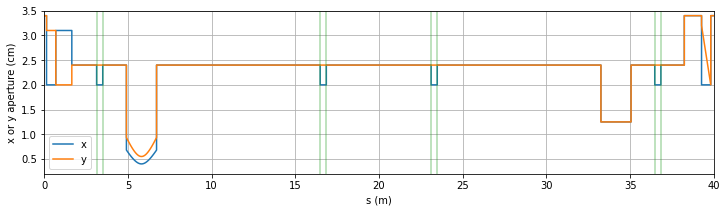

In [4]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.plot(aperture[:,0],(aperture[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [5]:
aperture[-1,0]

39.968229720000004

# read impact lattice

In [6]:
beam,lattice = impact.readInputFile('test.Chad.in')

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg
print('\n\n emitN =',emitN)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


 emitN = 2.4105916749973357e-07


In [7]:
beam.distribution.alfx = 3.860846841e-5
beam.distribution.betx = 0.561065822
beam.distribution.alfy = 2.282987698e-9
beam.distribution.bety = 1.385141718
beam.distribution.emitx = emitN
beam.distribution.emity = emitN
beam.distribution.betz  = 200
beam.distribution.alfz  = 0.0
beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz
beam.distribution.distribution_type = 'Gauss_trunc'
beam.distribution.CLx = 3.0
beam.distribution.CLy = 3.0
beam.distribution.CLz = 3.0
beam.n_particles = npt
beam.nCore_y = 4
beam.nCore_z = 4

In [8]:
cleanLat = []
pre = lattice[0]
L = 0 
for item in lattice:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        print('NL:',L,L+item.length)
    if item.type not in ['-8', 'write_raw_ptcl', 'halt']:
        cleanLat.append(item)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


# run Impact

In [9]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

In [10]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat[1].turns = nturn

In [11]:
writeP = impact.getElem('write_raw_ptcl')
writeP.file_id = 3456
writeP.format_id = 2
cleanLat.insert(2,writeP)

In [12]:
cleanLat[3]


      length: 0.02 [m]
    n_sckick: 1 [1]
       n_map: 1 [1]
 pipe_radius: 1.0 [m]
        type: 'drift'

In [13]:
impact.writeInputFile(beam,cleanLat)
impact.run(beam)

0

In [14]:
pData = impact.readParticleData(3456,ke,mass,freq,2)

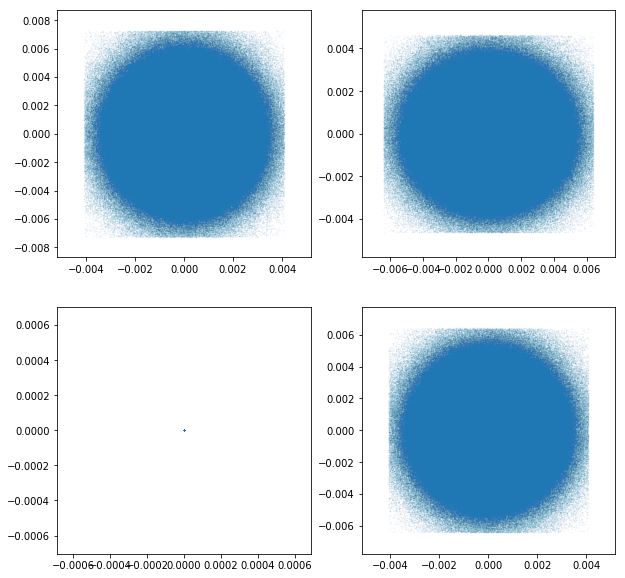

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(pData[:,0],pData[:,1],s=0.1,alpha=0.1)
plt.subplot(2,2,2)
plt.scatter(pData[:,2],pData[:,3],s=0.1,alpha=0.1)
plt.subplot(2,2,3)
plt.scatter(pData[:,4],pData[:,5],s=0.1,alpha=0.1)
plt.subplot(2,2,4)
plt.scatter(pData[:,0],pData[:,2],s=0.1,alpha=0.1)

In [16]:
np.std(pData[:,5]/ke)

1.972936668912014e-22

In [17]:
lostp = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,4))

In [18]:
np.save('lost_partcl.I=0.NLon.noEspread.npy',lostp)

In [19]:
lostp=np.load('lost_partcl.I=0.NLon.noEspread.npy')

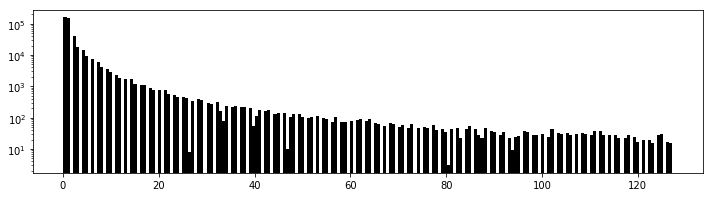

In [20]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0]/L,bins=200,color='k');
plt.yscale('log')

In [21]:
lostp[:,0] = np.mod(lostp[:,0],L)
lostp.shape

(446451, 4)

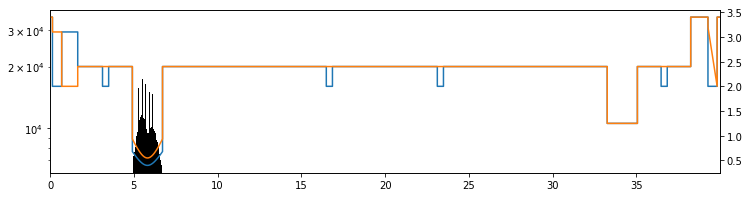

In [22]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0],bins=40,color='k');
plt.xlim(0,L)
plt.yscale('log')
plt.twinx()
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)

(-0.012, 0.012)

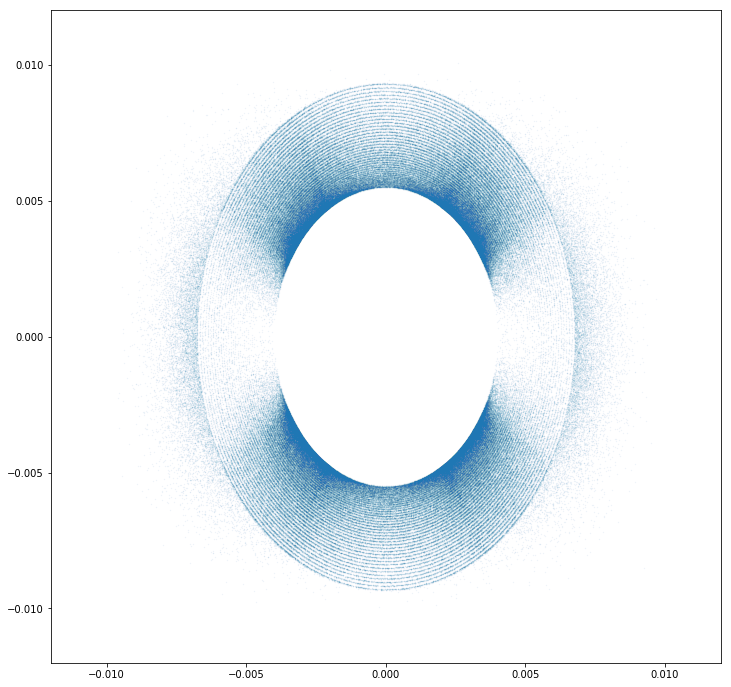

In [23]:
plt.figure(figsize=(12,12))
plt.scatter(lostp[:,1],lostp[:,2],s=0.1,alpha=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)